과제: 파이썬 딥러닝 텐서플로 ch4.7 필사

마감: 6월 21일 금요일 18:30

​

교재 229p~240p를 필사하여 링크를 올려주세요.

# Part 04. 합성곱 신경망(CNN)
## 04-07. 이미지 분할 (Segmentation)

이미지 분할(segmentation)은 이미지를 구성하는 모든 픽셀을 픽셀 단위로 분류하는 것이다. 즉 모든 픽셀은 어떤 클래스에 속한다.
1. 의미 분할 (semantic segmentation) : 같은 범주의 여러 객체를 하나의 범주로 묶어서 구분
2. 인스턴스 분할 (instance segmentation) : 같은 범주에 속하더라도 서로 다른 객체를 구분

----
### 7-1 데이터셋 준비
반려동물의 이미지 및 분류 레이블, 각 이미지를 구성하는 픽셀 단위의 마스크로 구성. 각 픽셀은 다음 세 가지 범주 중 하나에 속한다.
- class1: 반려동물이 속한 픽셀
- class2: 반려동물과 인접한 픽셀
- class3: 위에 속하지 않는 모든 경우 / 주변 픽셀


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

In [2]:
#이미지크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w, img_h, img_c)

# 모델 학습
epoch_num = 5
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

메타정보를 info변수에 저장해준다.

In [3]:
# 텐서플로 데이터셋 로드
ds_str = 'oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.AQ09C4_3.2.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.AQ09C4_3.2.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
# 이미지 전처리 함수
def preprocess_image(ds):
  # 원본 이미지
  img = tf.image.resize(ds['image'],(img_w, img_h))
  img = tf.cast(img, tf.float32) / 255.0
  # 분할 마스크
  mask = tf.image.resize(ds['segmentation_mask'],(img_w, img_h))
  mask = tf.cast(mask, tf.int32)
  mask = mask - 1
  return img, mask

In [5]:
# 데이터 전처리 파이프라인
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


In [6]:
# 샘플 배치 선택
img, mask = next(iter(train_ds))
len(img)

16

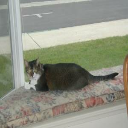

In [7]:
# 샘플 이미지 출력
img = np.array(img[0]) * 255.0
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

마스크 이미지를 출력한다. 마스크 범위는 0~2이므로 2로 나눈뒤 255를 곱하면 RGB이미지로 표현할 수 있다.

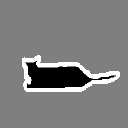

In [8]:
# 샘플 마스크 출력
mask = (np.array(mask[0])/2)*255.0
cv2_imshow(mask)

----
### 7-2 U-Net모델(인코더-디코더)

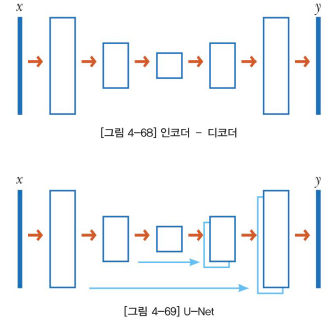

사전학습된 VGG16모델을 인코더로 활용하는 U-Net모델을 만들어본다. VGC16은 이미지넷 경진 대회를 통해 성능이 검증된 모델이다. 사실 데이터 개수가 충분하고, 시간이 충분하다면 사전 학습된 모델 없이 U-Net을 구성하여 학습을 진행해도 학습은 된다. 우리는 구글 코랩 환경에서 제한된 자원으로 양호한 성능을 갖는 모델을 만들기 위해 사전 학습된 모델을 베이스 모델로 사용하기로 한다.

먼저 VGC16 모델을 최종 레이어를 제외한 채로 불러온다

In [9]:
# VGG16 모델
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


축소된 모델을 U-Net인코더로 사용한다. 인코더는 원본 이미지 중에서 같은 범주에 속하는 픽셀을 결합하면서 점진적으로 이미지를 더 작은 크기로 축소한다. 즉 마스크 정답을 활용하여 각 픽셀의 마스크 범주를 0, 1, 2 중에 하나로 분류하는 역할을 한다.

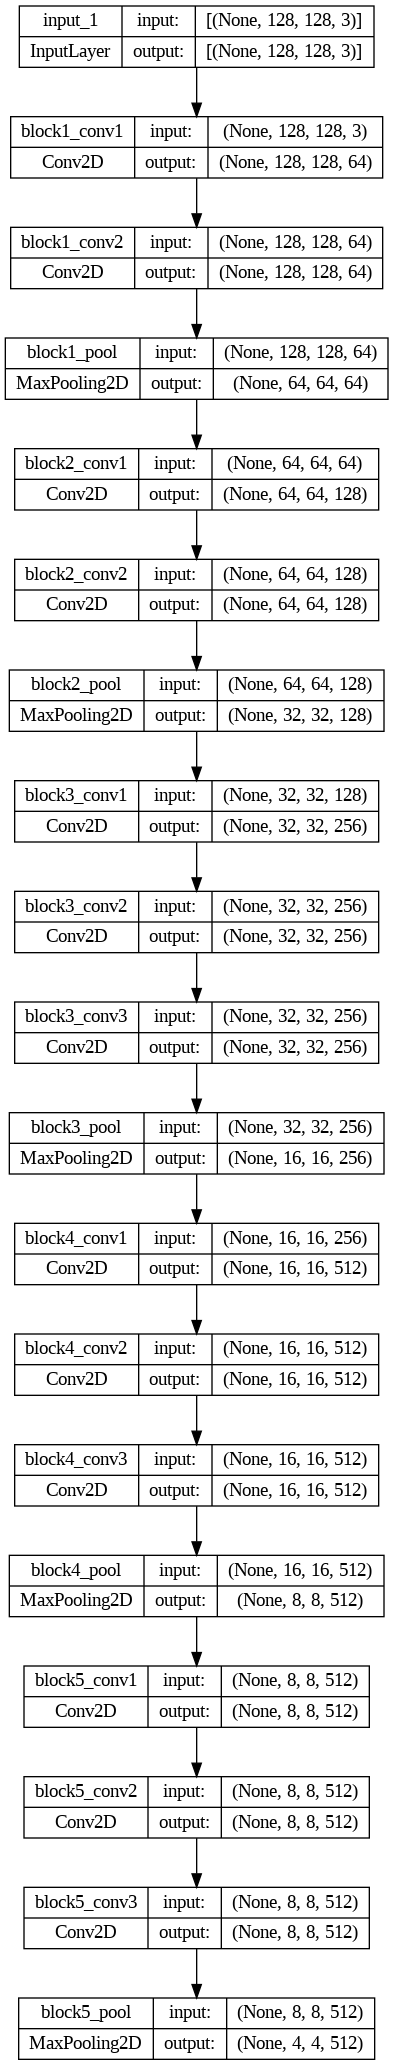

In [10]:
# 모델 구조
tf.keras.utils.plot_model(base_model, show_shapes=True)

VGC16 모델의 중간 레이어 중에서 필요한 출력 텐서를 지정하여, 다양한 피처(특징)를 추출하는 인코더 모델을 정의
여기서는 VGC16 모델로부터 5개의 출력을 가져와서 사용한다.
새로운 Feature Extractor 모델을 정의하고, f_model 변수에 저장.

In [11]:
# VGG16 중간 레이어 출력 텐서를 지정
f_model = tf.keras.Model(inputs=[base_model.input],
                         outputs=[
                                  base_model.get_layer(name='block5_conv3').output,
                                  base_model.get_layer(name='block4_conv3').output,
                                  base_model.get_layer(name='block3_conv3').output,
                                  base_model.get_layer(name='block2_conv2').output,
                                  base_model.get_layer(name='block1_conv2').output,
                         ])

In [12]:
# 파라미터 고정
f_model.trainable = False

In [13]:
# U-Net 구조로 모델 정의

i = tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out, out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_128_128_64])

out = tf.keras.layers.Conv2D(3, 3, activation='elu', padding='same')(out)
out = tf.keras.layers.Dense(3, activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

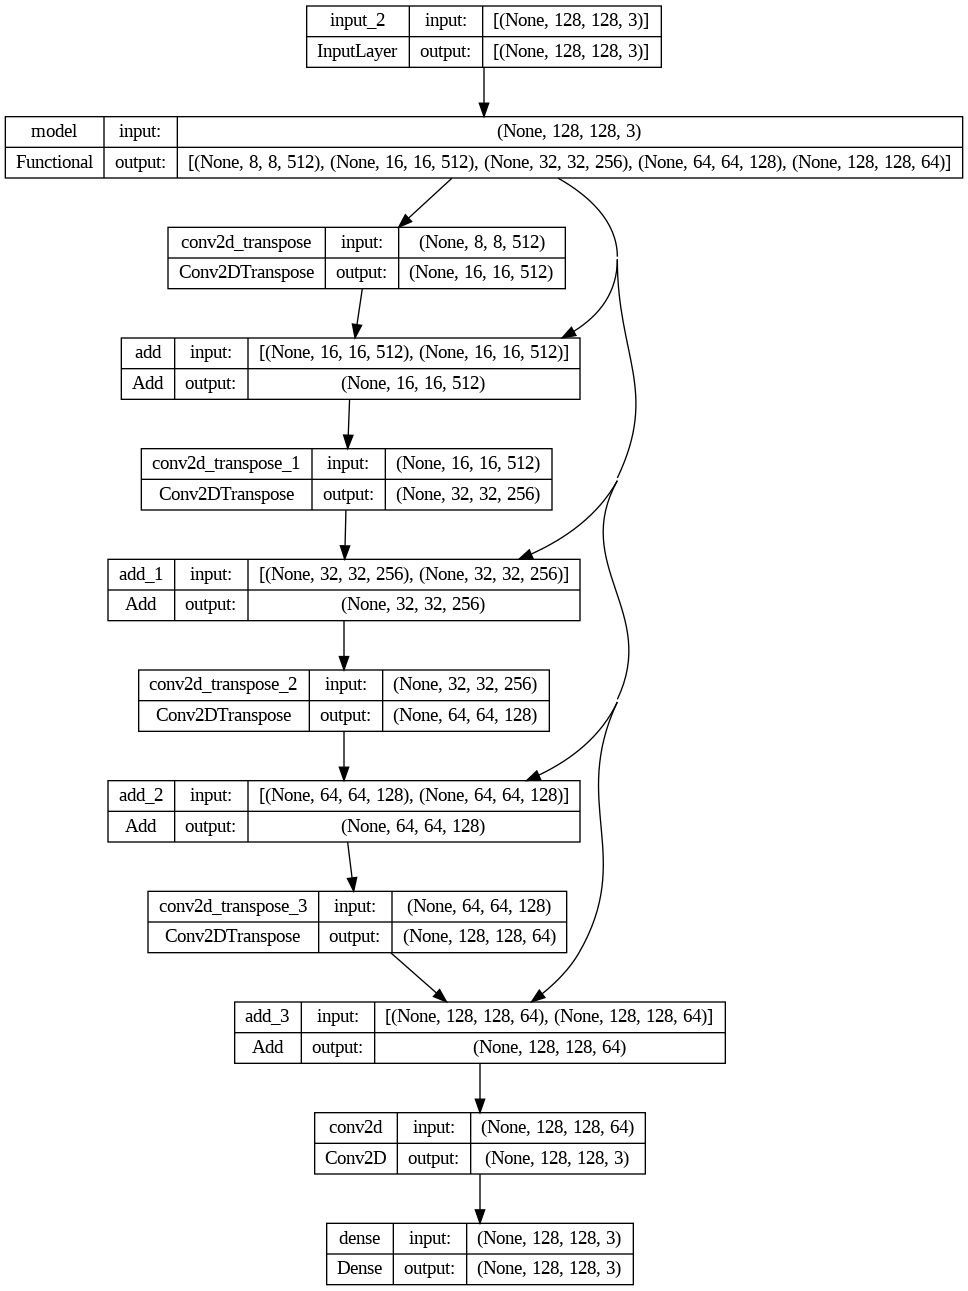

In [14]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [15]:
# 모델 요약
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 8, 8, 512),          1471468   ['input_2[0][0]']             
                              (None, 16, 16, 512),        8                                       
                              (None, 32, 32, 256),                                                
                              (None, 64, 64, 128),                                                
                              (None, 128, 128, 64)]                                               
                                                                                            

예측클래스 개수가 3개인 다중분류 문제에 맞도록 SparseCategoricalCrosstropy 손실함수를 선정하고 Adam옵티마이저를 적용한다.

In [16]:
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/5
230/230 [==============================] - 35s 79ms/step - loss: 0.9638 - accuracy: 0.6828
Epoch 2/5
230/230 [==============================] - 21s 80ms/step - loss: 0.6382 - accuracy: 0.8015
Epoch 3/5
230/230 [==============================] - 22s 81ms/step - loss: 0.6003 - accuracy: 0.8133
Epoch 4/5
230/230 [==============================] - 20s 79ms/step - loss: 0.5705 - accuracy: 0.8215
Epoch 5/5
230/230 [==============================] - 22s 81ms/step - loss: 0.5508 - accuracy: 0.8259


1/1 [==============================] - 0s 302ms/step


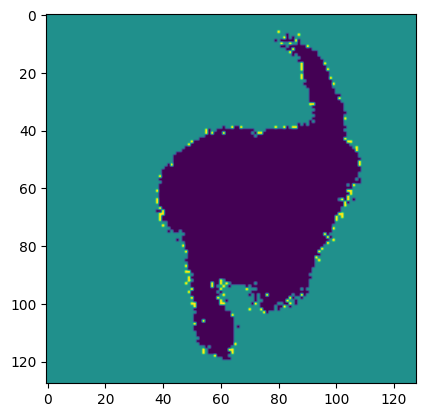

In [17]:
# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫 번째 이미지 분할 결과를 출력
pred_img = np.argmax(pred[0], -1)
plt.imshow(pred_img)

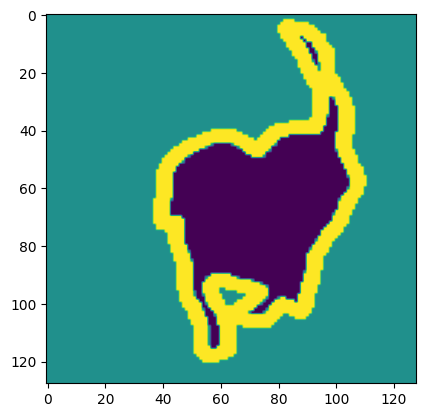

In [18]:
# 첫 번쨰 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0],(128,128)))

정답이미지를 출력하여 예측 분할이미지와 비교한다.